# FEEMS Basic Example

This notebook provides a comprehensive introduction to FEEMS (Fuel, Emissions, Energy Calculation for Machinery System).

## What You'll Learn

1. **Component Creation**: Build individual components (engines, generators, motors)
2. **Serial Systems**: Combine components into functional units (gensets, propulsion drives)
3. **System Integration**: Create complete electric power systems
4. **Power Balance**: Calculate power distribution across the system
5. **Fuel & Emissions**: Compute fuel consumption and environmental impact

## Use Case

We'll model a **dual-bus electric power system** for a vessel with:
- Two generator sets (different capacities on separate buses)
- Two electric propulsion drives (thrusters)
- Auxiliary hotel loads
- Bus-tie connection for redundancy

## 1. Setup and Data Loading

First, we'll load the necessary Python packages and configuration data from JSON files that define our equipment specifications.

**Data Files**:
- `equipment_data.json`: Component specifications (engines, generators, converters)
- `configuration.json`: System layout (how components connect to switchboards)

In [1]:
import json
import numpy as np
import pandas as pd
from feems.components_model import Engine, ElectricMachine, Genset
from feems.components_model.component_electric import SerialSystemElectric, ElectricComponent
from feems.system_model import ElectricPowerSystem, IntegrationMethod
from feems.types_for_feems import TypePower, TypeComponent
from utils import get_type_component, get_component_configuration_data, \
    get_component_data_from_name, get_configured_component_from_name, \
    create_components_for_an_electric_system
import matplotlib.pyplot as plt

In [2]:
component_data, configuration_data = get_component_configuration_data()
print("******* Component data *******")
print("These are the equipment specifications loaded from equipment_data.json")
print("Each component has: type, name, rated_power, and performance curves (BSFC or efficiency)")
component_data

******* Component data *******
These are the equipment specifications loaded from equipment_data.json
Each component has: type, name, rated_power, and performance curves (BSFC or efficiency)


[{'type': 'AUXILIARY_ENGINE',
  'name': 'Auxiliary engine 700',
  'rated_power': 700,
  'rated_speed': 1500,
  'bsfc_curve': [[0.25, 0.5, 0.75, 1.0], [280.0, 220.0, 200.0, 210.0]]},
 {'type': 'AUXILIARY_ENGINE',
  'name': 'Auxiliary engine 1000',
  'rated_power': 1000,
  'rated_speed': 1500,
  'bsfc_curve': [[0.25, 0.5, 0.75, 0.1], [250.0, 200.0, 180.0, 195.0]]},
 {'type': 'GENERATOR',
  'name': 'Generator A',
  'rated_power': 665,
  'rated_speed': 1500,
  'eff_curve': [[1.0, 0.75, 0.5, 0.25], [0.95, 0.94, 0.92, 0.88]]},
 {'type': 'GENERATOR',
  'name': 'Generator B',
  'rated_power': 950,
  'rated_speed': 1500,
  'eff_curve': [[1.0, 0.75, 0.5, 0.25], [0.95, 0.94, 0.92, 0.88]]},
 {'type': 'ELECTRIC_MOTOR',
  'name': 'Electric Motor A',
  'rated_power': 800,
  'rated_speed': 1200,
  'eff_curve': [[1.0, 0.75, 0.5, 0.25], [0.95, 0.96, 0.91, 0.86]]},
 {'type': 'ELECTRIC_MOTOR',
  'name': 'Electric Motor B',
  'rated_power': 600,
  'rated_speed': 1200,
  'eff_curve': [[1.0, 0.75, 0.5, 0.25]

In [3]:
print("******* Configuration data *******")
print("This defines how components are connected in the system:")
print("  - 'connected_to': shows the power flow chain")
print("  - 'switchboard_id': which electrical bus the component connects to")
print("  - Example: Aux engine 1 → Generator 1 → switchboard 1")
configuration_data

******* Configuration data *******
This defines how components are connected in the system:
  - 'connected_to': shows the power flow chain
  - 'switchboard_id': which electrical bus the component connects to
  - Example: Aux engine 1 → Generator 1 → switchboard 1


[{'name': 'Aux engine 1',
  'component': 'Auxiliary engine 700',
  'switchboard_id': 1,
  'shaftline_id': None,
  'connected_to': 'Generator 1'},
 {'name': 'Aux engine 2',
  'component': 'Auxiliary engine 1000',
  'switchboard_id': 2,
  'shaftline_id': None,
  'connected_to': 'Generator 2'},
 {'name': 'Generator 1',
  'component': 'Generator A',
  'switchboard_id': 1,
  'shaftline_id': None,
  'connected_to': 'switchboard'},
 {'name': 'Generator 2',
  'component': 'Generator B',
  'switchboard_id': 2,
  'shaftline_id': None,
  'connected_to': 'switchboard'},
 {'name': 'Thruster motor 1',
  'component': 'Electric Motor A',
  'switchboard_id': 1,
  'shaftline_id': None,
  'connected_to': 'Inverter 1'},
 {'name': 'Thruster motor 2',
  'component': 'Electric Motor B',
  'switchboard_id': 2,
  'shaftline_id': None,
  'connected_to': 'Inverter 2'},
 {'name': 'Inverter 1',
  'component': 'Inverter',
  'switchboard_id': 1,
  'shaftline_id': None,
  'connected_to': 'Rectifier 1'},
 {'name': 'In

## Example 1: Create an Atomic Component

**Atomic components** are the basic building blocks in FEEMS. Each component represents a single piece of equipment.

Here we'll create an auxiliary engine with:
- Rated power: 700 kW
- Rated speed: 1500 RPM
- BSFC curve: defines fuel consumption at different load points

In [4]:
engine_component = get_configured_component_from_name('Aux engine 1', configuration_data)
engine_component_data = get_component_data_from_name(engine_component['component'], component_data)
aux_engine_1 = Engine(
    type_=get_type_component(engine_component_data['type']),
    name=engine_component['name'],
    rated_power=engine_component_data['rated_power'],
    rated_speed=engine_component_data['rated_speed'],
    bsfc_curve=np.asarray(engine_component_data['bsfc_curve']).transpose()
)
aux_engine_1

### Calculate the Fuel Consumption for a Given Power Load

Now we'll calculate how much fuel the engine consumes at 450 kW output.

**Key metrics**:
- **BSFC** (Brake Specific Fuel Consumption): g fuel per kWh of work
- **Load ratio**: Percentage of rated power (450/700 = 64.3%)
- **Fuel flow rate**: kg/s instantaneous consumption

In [5]:
power_output = 450.0

engine_run_points = \
    aux_engine_1.get_engine_run_point_from_power_out_kw(power_output)

columns = ["Power [kW]", "Fuel consumption [kg/s]", "Load [%]", "BSFC [g/kWh]"]
columns_to_print = [column + '\t' for column in columns]
fuel_consumption = engine_run_points.fuel_flow_rate_kg_per_s.fuels[0].mass_or_mass_fraction
perc_load = engine_run_points.load_ratio * 100
bsfc = engine_run_points.bsfc_g_per_kWh
print(''.join(columns_to_print))
print(f"{power_output:3.2f}\t\t{fuel_consumption:5.5f}\t\t\t{perc_load:3.1f}\t\t{bsfc:3.1f}")

Power [kW]	Fuel consumption [kg/s]	Load [%]	BSFC [g/kWh]	
450.00		0.02559			64.3		204.7


### Calculate Fuel Consumption Across the Load Range

Let's see how fuel consumption varies from 0 to full load.

**Expected behavior**:
- BSFC is highest at very low loads (poor efficiency)
- BSFC improves at medium loads (optimal efficiency zone)
- BSFC may increase slightly at full load (mechanical stress)

This is why operating engines at 60-80% load is typically most efficient.

In [6]:
power_output = np.arange(start=0, stop=710, step=50)
aux_engine_1.power_output = power_output

engine_run_points = \
    aux_engine_1.get_engine_run_point_from_power_out_kw()
fuel_consumption = engine_run_points.fuel_flow_rate_kg_per_s.fuels[0].mass_or_mass_fraction
perc_load = engine_run_points.load_ratio * 100
bsfc = engine_run_points.bsfc_g_per_kWh
data = np.array([fuel_consumption, perc_load * 100, bsfc]).transpose()
df = pd.DataFrame(data, index=power_output, columns=columns[1:])
print(df)

     Fuel consumption [kg/s]      Load [%]  BSFC [g/kWh]
0                   0.000000      0.000000    360.000000
50                  0.004703    714.285714    338.600583
100                 0.008759   1428.571429    315.335277
150                 0.012150   2142.857143    291.603499
200                 0.014934   2857.142857    268.804665
250                 0.017246   3571.428571    248.338192
300                 0.019300   4285.714286    231.603499
350                 0.021389   5000.000000    220.000000
400                 0.023518   5714.285714    211.661808
450                 0.025590   6428.571429    204.723032
500                 0.027859   7142.857143    200.583090
550                 0.030573   7857.142857    200.116618
600                 0.033552   8571.428571    201.311953
650                 0.036901   9285.714286    204.373178
700                 0.040833  10000.000000    210.000000


### Visualize the Engine Performance Curves

These plots show:
- **Left**: Fuel consumption rate vs. load percentage
- **Right**: BSFC (specific fuel consumption) vs. load percentage

The characteristic U-shape of the BSFC curve is typical for diesel engines.

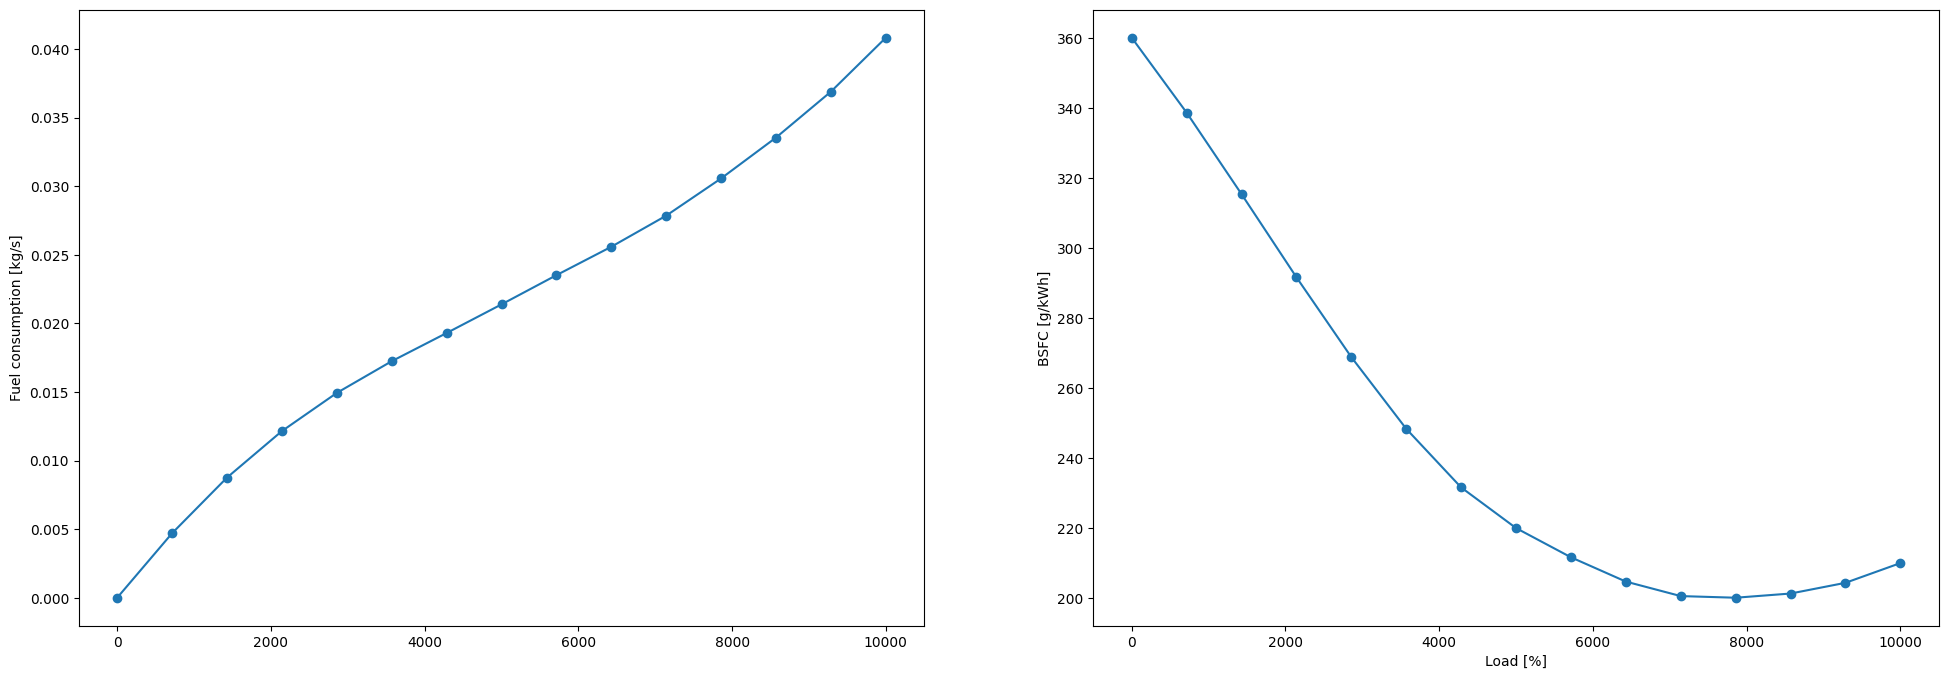

In [7]:
plt.figure(figsize=[24, 8])
plt.subplot(1,2,1)
plt.plot(df[columns[2]], df[columns[1]], 'o-')
plt.ylabel(columns[1])
plt.subplot(1,2,2)
plt.plot(df[columns[2]], df[columns[3]], 'o-')
plt.ylabel(columns[3])
plt.xlabel(columns[2])

plt.show()

## Example 2: Create a Serial Component

**Serial components** chain multiple components together to model complete subsystems.

### Creating a Generator

A generator converts mechanical power (from the engine shaft) to electrical power.

**Key parameters**:
- **Efficiency curve**: How efficiently it converts mechanical to electrical power
- **Power type**: POWER_SOURCE (generates electricity)
- **Switchboard ID**: Which electrical bus it connects to

In [8]:
generator_component = get_configured_component_from_name('Generator 1', configuration_data)
generator_data = get_component_data_from_name(generator_component['component'], component_data)

generator_1 = ElectricMachine(
    type_=generator_data['type'],
    name=generator_component['name'],
    rated_power=generator_data['rated_power'],
    rated_speed=generator_data['rated_speed'],
    power_type=TypePower.POWER_SOURCE,
    switchboard_id=generator_component['switchboard_id'],
    eff_curve=np.asarray(generator_data['eff_curve']).transpose()
)
generator_1

### Creating a Genset Component

A **Genset** is a serial component combining:
1. **Auxiliary Engine**: Produces mechanical power
2. **Generator**: Converts mechanical → electrical power

**Power flow**: Fuel → Engine → Shaft Power → Generator → Electrical Power

This abstraction allows us to calculate end-to-end efficiency in one step.

In [9]:
genset_1 = Genset(
    name="Genset 1",
    aux_engine=aux_engine_1,
    generator=generator_1
)
genset_1

### Compare Two Calculation Methods

We'll verify that the genset component gives the same results as calculating separately:

**Method 1** (separate): Generator output → Generator input (shaft power) → Engine fuel
**Method 2** (genset): Generator output → Genset fuel (one step)

Both should yield identical results, demonstrating that serial components correctly model the power chain.

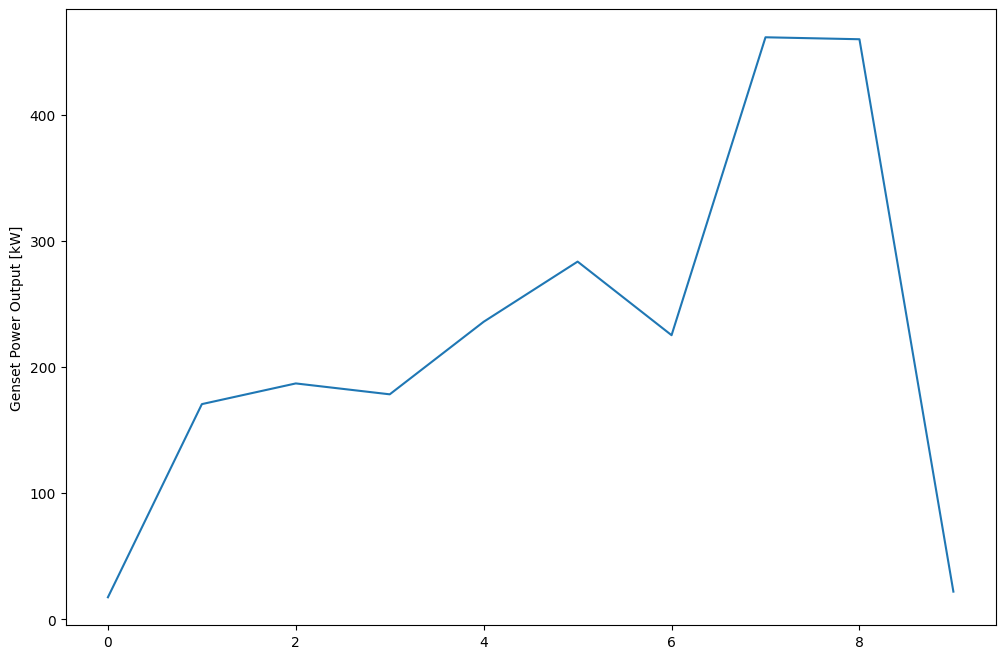

In [10]:
power_output = genset_1.rated_power * np.random.random(10)
plt.figure(figsize=[12, 8])
plt.plot(power_output)
plt.ylabel('Genset Power Output [kW]')

plt.show()

#### Method 1: Calculate Using Components Separately

First, we calculate the generator's shaft power requirement (power input) from its electrical output.

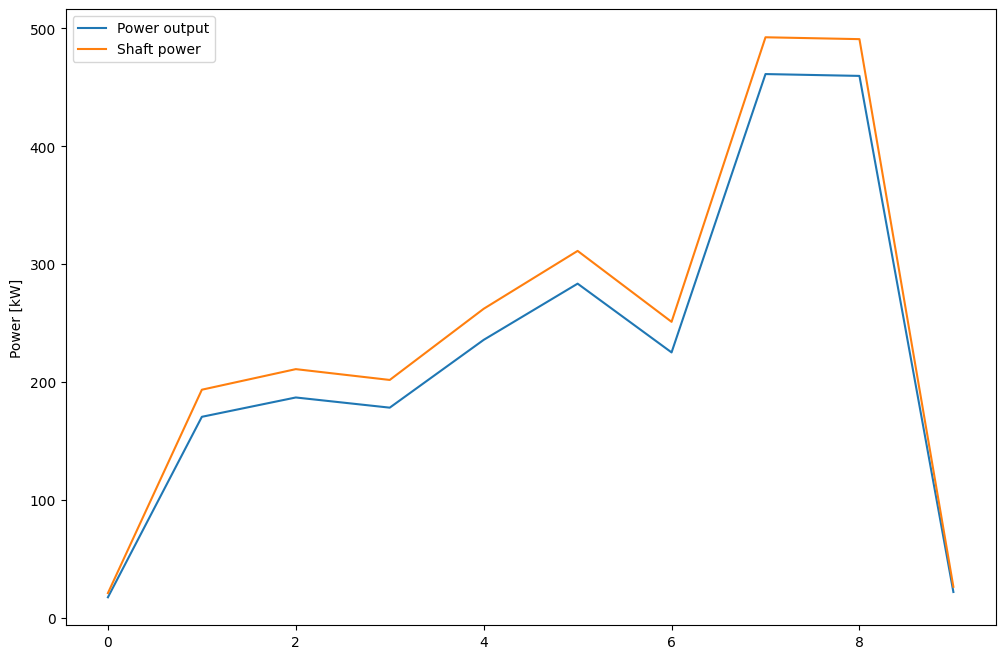

In [11]:
generator_1.set_power_input_from_output(power_output)
plt.figure(figsize=[12, 8])
plt.plot(power_output)
plt.plot(generator_1.power_input)
plt.ylabel('Power [kW]')
plt.legend(['Power output', 'Shaft power'])

plt.show()

Now calculate the engine fuel consumption from the shaft power demand.

The results show fuel consumption, load percentage, and BSFC for each random power point.

In [12]:
aux_engine_1.power_output = generator_1.power_input
engine_run_points = aux_engine_1.get_engine_run_point_from_power_out_kw()
fuel_consumption_ref = engine_run_points.fuel_flow_rate_kg_per_s.fuels[0].mass_or_mass_fraction
perc_load_ref = engine_run_points.load_ratio * 100
bsfc_ref = engine_run_points.bsfc_g_per_kWh
data = np.array([fuel_consumption_ref, perc_load_ref, bsfc_ref]).transpose()
df_ref = pd.DataFrame(data, index=power_output, columns=columns[1:])
print(df_ref)

            Fuel consumption [kg/s]   Load [%]  BSFC [g/kWh]
17.573809                  0.002060   3.016257    351.280914
170.610837                 0.014607  27.655493    271.627232
187.001984                 0.015478  30.147432    264.039443
178.368428                 0.015027  28.837681    267.991237
235.857930                 0.017761  37.457688    243.855852
283.521484                 0.019757  44.470629    228.483783
225.214604                 0.017295  35.878054    247.907362
461.249723                 0.027491  70.349211    200.973851
459.694241                 0.027416  70.123461    201.067252
22.051490                  0.002564   3.778177    348.998832


#### Method 2: Calculate Using the Serial Component

The genset component performs the two-step calculation automatically.

The results should match the previous calculation exactly, confirming the serial component works correctly.

In [13]:
genset_run_points = \
    genset_1.get_fuel_cons_load_bsfc_from_power_out_generator_kw(power_output)
engine_run_points = genset_run_points.engine
fuel_consumption = engine_run_points.fuel_flow_rate_kg_per_s.fuels[0].mass_or_mass_fraction
perc_load = engine_run_points.load_ratio * 100
bsfc = engine_run_points.bsfc_g_per_kWh
data = np.array([fuel_consumption, perc_load, bsfc]).transpose()
df = pd.DataFrame(data, index=power_output, columns=columns[1:])
print(df)

            Fuel consumption [kg/s]   Load [%]  BSFC [g/kWh]
17.573809                  0.002060   3.016257    351.280914
170.610837                 0.014607  27.655493    271.627232
187.001984                 0.015478  30.147432    264.039443
178.368428                 0.015027  28.837681    267.991237
235.857930                 0.017761  37.457688    243.855852
283.521484                 0.019757  44.470629    228.483783
225.214604                 0.017295  35.878054    247.907362
461.249723                 0.027491  70.349211    200.973851
459.694241                 0.027416  70.123461    201.067252
22.051490                  0.002564   3.778177    348.998832


### Creating Electric Serial Components

Electric serial systems model complete power conversion chains.

Here we'll create a **propulsion drive** with four components in series:
1. **Transformer**: Voltage transformation
2. **Rectifier**: AC → DC conversion (Active Front End)
3. **Inverter**: DC → AC conversion (variable frequency)
4. **Electric Motor**: Electrical → mechanical power (thruster)

**Application**: Variable-speed electric propulsion (common in modern vessels)

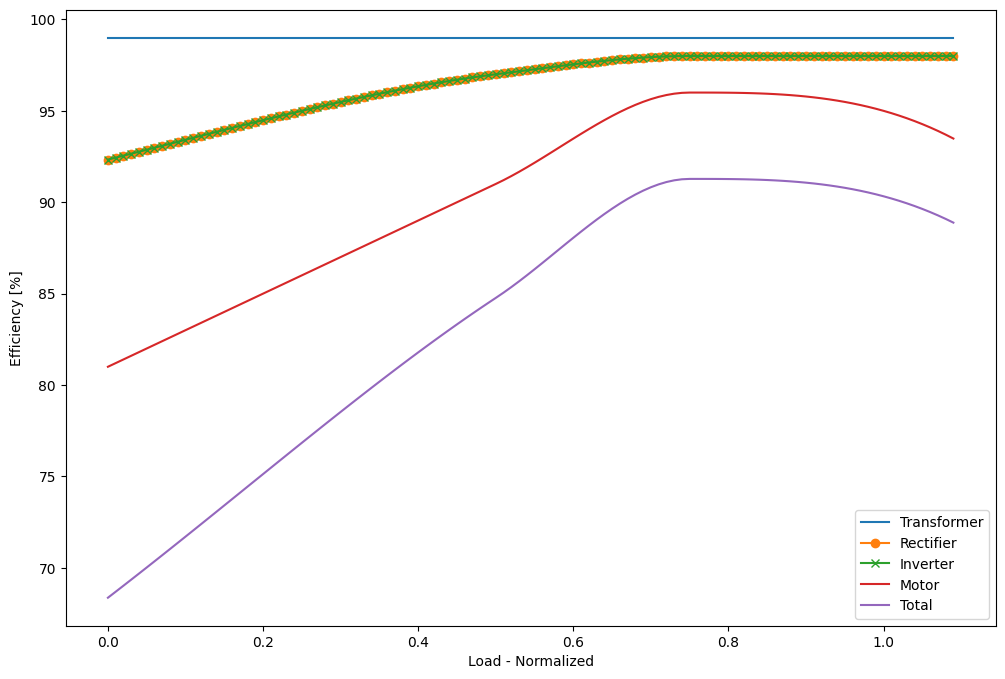

In [14]:
transformer_component = get_configured_component_from_name('Transformer 1', configuration_data)
transformer_component_data = get_component_data_from_name(transformer_component['component'], component_data)
transformer_1 = ElectricComponent(
    type_=get_type_component(transformer_component_data['type']),
    name=transformer_component['name'],
    rated_power=transformer_component_data['rated_power'],
    eff_curve=np.asarray(transformer_component_data['eff_curve']).transpose(),
    power_type=TypePower.POWER_TRANSMISSION,
    switchboard_id=transformer_component['switchboard_id'],
)

rectifier_component = get_configured_component_from_name('Rectifier 1', configuration_data)
rectifier_component_data = get_component_data_from_name(rectifier_component['component'], component_data)
rectifier_1 = ElectricComponent(
    type_=get_type_component(rectifier_component_data['type']),
    name=rectifier_component['name'],
    rated_power=rectifier_component_data['rated_power'],
    eff_curve=np.asarray(rectifier_component_data['eff_curve']).transpose(),
    power_type=TypePower.POWER_TRANSMISSION,
    switchboard_id=rectifier_component['switchboard_id'],
)

inverter_component = get_configured_component_from_name('Inverter 1', configuration_data)
inverter_component_data = get_component_data_from_name(inverter_component['component'], component_data)
inverter_1 = ElectricComponent(
    type_=get_type_component(inverter_component_data['type']),
    name=inverter_component['name'],
    rated_power=inverter_component_data['rated_power'],
    eff_curve=np.asarray(inverter_component_data['eff_curve']).transpose(),
    power_type=TypePower.POWER_TRANSMISSION,
    switchboard_id=inverter_component['switchboard_id'],
)

electric_motor_component = get_configured_component_from_name('Thruster motor 1', configuration_data)
electric_motor_component_data = get_component_data_from_name(electric_motor_component['component'], component_data)
thruster_motor_1 = ElectricMachine(
    type_=get_type_component(electric_motor_component_data['type']),
    name=electric_motor_component['name'],
    rated_power=electric_motor_component_data['rated_power'],
    rated_speed=electric_motor_component_data['rated_speed'],
    eff_curve=np.asarray(electric_motor_component_data['eff_curve']).transpose(),
    power_type=TypePower.POWER_CONSUMER,
    switchboard_id=electric_motor_component['switchboard_id'],
)

plt.figure(figsize=[12, 8])
load = np.arange(start=0.0, stop=1.1, step=0.01)
eff_transformer_1 = transformer_1.get_efficiency_from_load_percentage(load)
eff_rectifier_1 = rectifier_1.get_efficiency_from_load_percentage(load)
eff_inverter_1 = inverter_1.get_efficiency_from_load_percentage(load)
eff_thruster_motor_1 = thruster_motor_1.get_efficiency_from_load_percentage(load)
total_efficiency = eff_thruster_motor_1 * eff_rectifier_1 * eff_inverter_1 * eff_transformer_1
plt.plot(load, eff_transformer_1 * 100)
plt.plot(load, eff_rectifier_1 * 100, '-o')
plt.plot(load, eff_inverter_1 * 100, '-x')
plt.plot(load, eff_thruster_motor_1 * 100)
plt.plot(load, total_efficiency * 100)
plt.ylabel('Efficiency [%]')
plt.xlabel('Load - Normalized')
plt.legend(['Transformer', 'Rectifier', 'Inverter', 'Motor', 'Total'])

### Create the Propulsion Drive

Now we combine all four components into a single `SerialSystemElectric`.

**Benefits**:
- Calculate total efficiency through the entire chain
- Determine switchboard power from shaft power (or vice versa)
- Simplifies system-level modeling

In [15]:
propulsion_drive_1 = SerialSystemElectric(
    type_=TypeComponent.PROPULSION_DRIVE,
    name="Propulsion drive 1",
    power_type=TypePower.POWER_CONSUMER,
    components=[transformer_1, rectifier_1, inverter_1, thruster_motor_1],
    rated_power=thruster_motor_1.rated_power,
    rated_speed=thruster_motor_1.rated_speed,
    switchboard_id=transformer_1.switchboard_id
)

### Calculate Power Through the Conversion Chain

Given shaft power output (mechanical power to the propeller), we can calculate:
- Electrical power input at the switchboard
- Conversion efficiency
- Load percentage

**Power flow**: Switchboard → Transformer → Rectifier → Inverter → Motor → Shaft

Each component contributes losses, reducing overall efficiency.

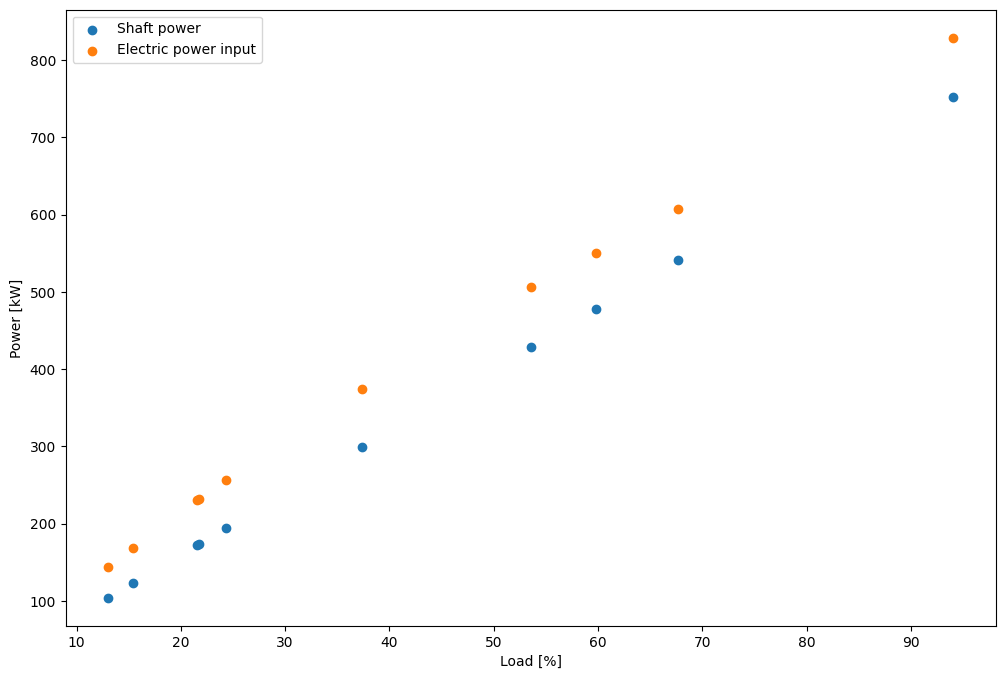

           El power [kW]  Shaft power[kW]  Efficiency [%]
13.003953     143.904130       104.031627       72.292315
15.361795     168.306529       122.894363       73.018179
21.563533     230.179470       172.508265       74.945114
21.698036     231.485893       173.584287       74.986983
24.330235     256.765853       194.641881       75.805205
37.360723     374.355346       298.885787       79.840128
53.604253     505.617522       428.834025       84.813917
59.784551     550.418991       478.276406       86.893151
67.619460     607.460045       540.955681       89.052060
94.070912     828.821052       752.567294       90.799732


In [16]:
power_output = propulsion_drive_1.rated_power * np.random.random(10)
power_input, load = propulsion_drive_1.set_power_input_from_output(power_output)
plt.figure(figsize=[12, 8])
plt.scatter(load*100, power_output)
plt.scatter(load*100, power_input)
plt.xlabel('Load [%]')
plt.ylabel('Power [kW]')
plt.legend(['Shaft power', 'Electric power input'])
plt.show()

data = np.array([power_input, power_output, power_output/power_input * 100]).transpose()
df = pd.DataFrame(data, index=load*100, columns=['El power [kW]', 'Shaft power[kW]', 'Efficiency [%]'])
df = df.sort_index()
print(df)

## Example 3: Create a System and Perform Power Balance

Now we'll build a **complete electric power system** with:
- **2 Gensets**: Power sources on separate buses
- **2 Propulsion drives**: Thruster loads
- **1 Auxiliary load**: Hotel loads (HVAC, lighting, etc.)
- **Bus-tie breaker**: Connects the two electrical buses for redundancy

This represents a typical dual-bus marine power system.

In [17]:
components = create_components_for_an_electric_system()
for component in components:
    print(component.name)
    print(component.switchboard_id)

Genset 1
1
Genset 2
2
Propulsion drive 1
1
Propulsion drive 2
2
Aux load
1


### Create the Electric Power System

The `ElectricPowerSystem` class automatically:
- Organizes components by type (sources, loads, propulsion)
- Creates switchboard objects for each bus
- Sets up bus-tie breakers for inter-bus connections

**Bus-tie connection (1,2)**: Allows power to flow between bus 1 and bus 2 when closed.

In [18]:
from feems.types_for_feems import TypePower
electric_power_system = ElectricPowerSystem(
    name='Power system',
    power_plant_components=components,
    bus_tie_connections=[(1,2)]
)
electric_power_system.__dict__

{'name': 'Power system',
 'power_sources': [<feems.components_model.component_electric.Genset at 0x115c50920>,
 'propulsion_drives': [<feems.components_model.component_electric.SerialSystemElectric at 0x115b08ec0>,
 'pti_pto': [],
 'energy_storage': [],
 'other_load': [<feems.components_model.component_electric.ElectricComponent at 0x115d3dca0>],
 'switchboards': {1: <feems.components_model.node.Switchboard at 0x115c523f0>,
  2: <feems.components_model.node.Switchboard at 0x115c22120>},
 'bus_tie_breakers': [<feems.components_model.node.BusBreaker at 0x115b09580>],
 'no_bus': [1],
 'switchboard2bus': [{1: 1, 2: 1}],
 'bus_tie_status_system': [array([ True])],
 'bus_configuration_change_index': [0],
 'switchboard_id': [1, 2],
 'no_bus_tie_breakers': 1,
 'no_power_sources': 2,
 'no_propulsion_units': 2,
 'no_energy_storage': 0,
 'no_pti_pto': 0,
 'no_other_load': 1,
 'no_switchboard': 2,
 'time_interval_s': [],
 'integration_method': <IntegrationMethod.simpson: 'simpson'>}

### Set Power Loads on Propulsion Drives

We generate random power profiles for the two thrusters.

**In practice**: These would come from:
- Ship speed and sea state calculations
- Dynamic positioning requirements
- Maneuvering operations

In [19]:
number_points_load = 100
shaft_power_on_propulsion_drive_1 = \
    electric_power_system.propulsion_drives[0].rated_power * np.random.random(number_points_load)
shaft_power_on_propulsion_drive_2 = \
    electric_power_system.propulsion_drives[1].rated_power * np.random.random(number_points_load)
electric_power_system.set_power_input_from_power_output_by_switchboard_id_type_name(
    power_output=shaft_power_on_propulsion_drive_1,
    switchboard_id=1,
    type_=TypePower.POWER_CONSUMER,
    name="Propulsion drive 1"
)
electric_power_system.set_power_input_from_power_output_by_switchboard_id_type_name(
    power_output=shaft_power_on_propulsion_drive_2,
    switchboard_id=2,
    type_=TypePower.POWER_CONSUMER,
    name="Propulsion drive 2"
)
electric_power_system

### Set Auxiliary Load

This represents hotel loads: HVAC, lighting, galley, pumps, etc.

**Typical ranges**:
- Small vessels: 50-200 kW
- Medium vessels: 200-500 kW
- Large vessels: 500-2000+ kW

In [20]:
auxiliary_load = 100 * np.random.random(number_points_load)
electric_power_system.set_power_input_from_power_output_by_switchboard_id_type_name(
    power_output=auxiliary_load,
    switchboard_id=1,
    type_=TypePower.POWER_CONSUMER,
    name="Aux load"
)

1

### Configure Generator Status and Load Sharing

For each time point, we must specify:

1. **Status**: Is the generator ON or OFF?
2. **Load sharing mode**: How do multiple generators split the load?
   - 0 = Equal sharing (default)
   - Custom values for weighted sharing

Here we keep both gensets running for the entire period with equal load sharing.

In [21]:
electric_power_system.set_status_by_switchboard_id_power_type(
    switchboard_id=1,
    power_type=TypePower.POWER_SOURCE,
    status = np.ones([number_points_load, 1]).astype(bool) # <== No. 1 genset is on for all periods
)
electric_power_system.set_load_sharing_mode_power_sources_by_switchboard_id_power_type(
    switchboard_id=1,
    power_type=TypePower.POWER_SOURCE,
    load_sharing_mode=np.zeros([number_points_load, 1])  # <== Equal load sharing
)
electric_power_system.set_status_by_switchboard_id_power_type(
    switchboard_id=2,
    power_type=TypePower.POWER_SOURCE,
    status = np.ones([number_points_load, 1]).astype(bool) # <== No. 2 genset is on for all periods
)
electric_power_system.set_load_sharing_mode_power_sources_by_switchboard_id_power_type(
    switchboard_id=2,
    power_type=TypePower.POWER_SOURCE,
    load_sharing_mode=np.zeros([number_points_load, 1])  # <== Equal load sharing
)

### Set Bus-Tie Breaker Status

The bus-tie breaker determines if the two buses operate:
- **Closed (True)**: Buses connected, gensets can share all loads
- **Open (False)**: Buses isolated, each genset serves only its own bus

**Scenario**: We close the breaker for the first 50 time points, then open it.

This simulates:
- First half: Normal operation with inter-bus power sharing
- Second half: Split operation (each bus independent)

In [22]:
status = np.ones([number_points_load, 1]).astype(bool)
status[int(number_points_load/2):,0] = False
electric_power_system.set_bus_tie_status_all(status)

### Perform Power Balance Calculation

`do_power_balance_calculation()` solves the power distribution problem:

**Inputs**: Load demands, generator status, load sharing modes
**Outputs**: Generator power outputs that satisfy all loads

**Algorithm**:
1. Sum all loads on each bus
2. Distribute load among available generators according to sharing rules
3. Handle bus-tie power flows if breaker is closed
4. Ensure power balance: Total generation = Total consumption

In [23]:
electric_power_system.set_time_interval(1, integration_method=IntegrationMethod.simpson)
electric_power_system.do_power_balance_calculation()

### Visualize Power Balance

These plots show how power flows through the system over time.

**Top plot** (first 20 points - bus-tie CLOSED):
- Gensets share loads across both buses
- More balanced loading

**Bottom plot** (points 50-70 - bus-tie OPEN):
- Each genset serves only its own bus
- Independent operation
- Genset 1 serves propulsion drive 1 + auxiliary load
- Genset 2 serves propulsion drive 2 only

**Power balance line**: Should be near zero (generation = consumption)

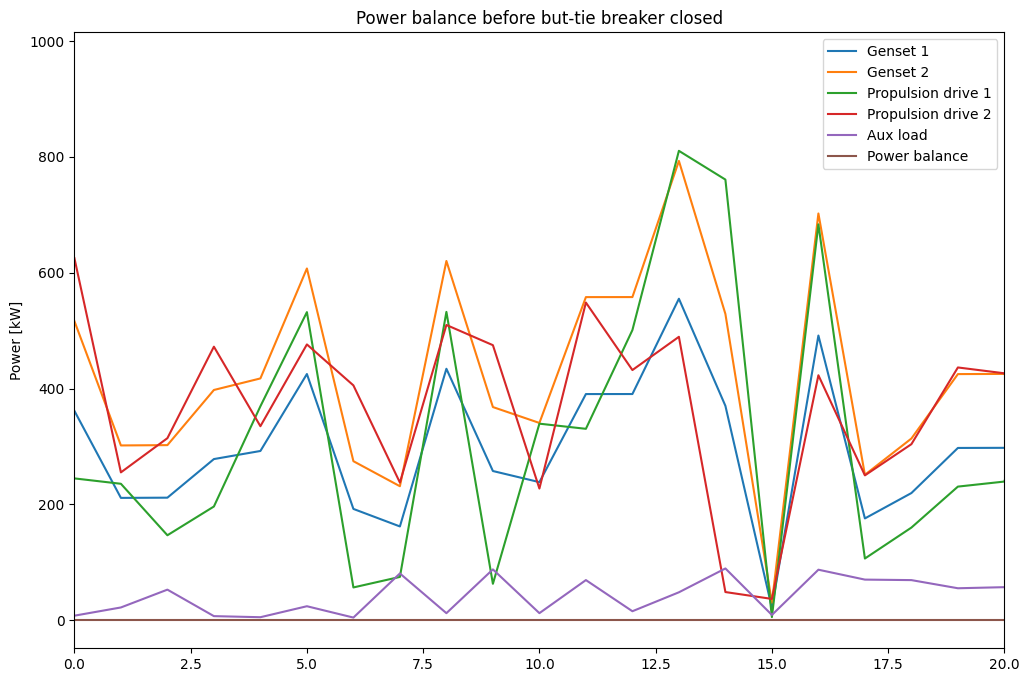

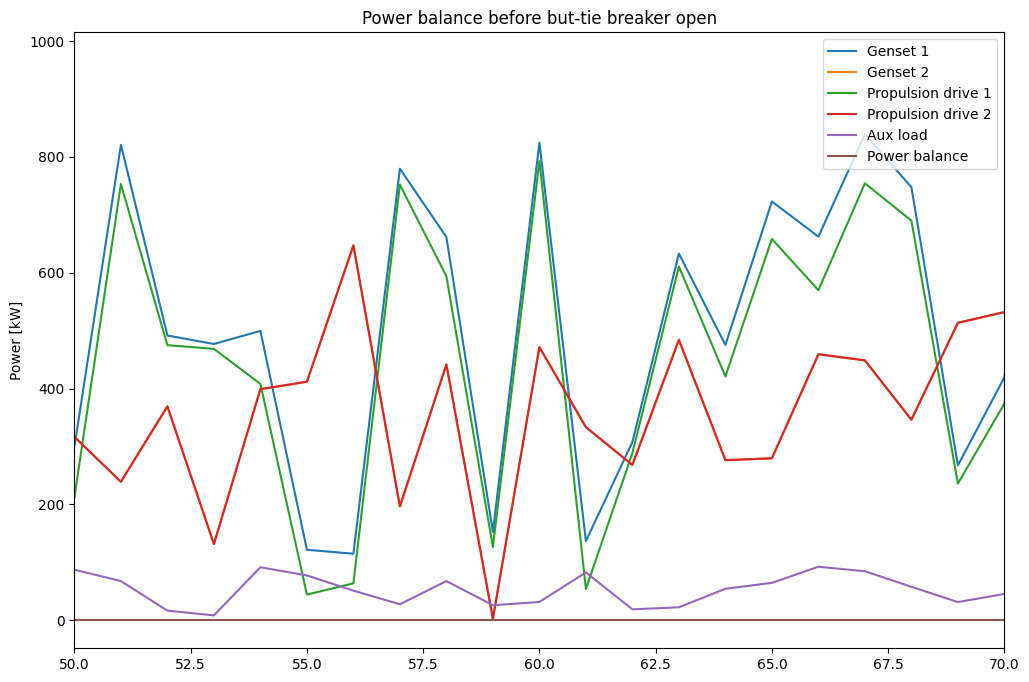

In [24]:
genset_1 = electric_power_system.power_sources[0]
genset_2 = electric_power_system.power_sources[1]
propulsion_drive_1 = electric_power_system.propulsion_drives[0]
propulsion_drive_2 = electric_power_system.propulsion_drives[1]
aux_load = electric_power_system.other_load[0]
power_balance = genset_1.power_output + genset_2.power_output - \
                propulsion_drive_1.power_input - propulsion_drive_2.power_input - aux_load.power_input

fig = plt.figure(figsize=[12, 8])
plt.plot(genset_1.power_output)
plt.plot(genset_2.power_output)
plt.plot(propulsion_drive_1.power_input)
plt.plot(propulsion_drive_2.power_input)
plt.plot(aux_load.power_input)
plt.plot(power_balance)
plt.ylabel('Power [kW]')
plt.xlim([0,20])
plt.title("Power balance before but-tie breaker closed")
plt.legend(['Genset 1', 'Genset 2', 'Propulsion drive 1', 'Propulsion drive 2', 'Aux load', 'Power balance'])

fig = plt.figure(figsize=[12, 8])
plt.plot(genset_1.power_output)
plt.plot(genset_2.power_output)
plt.plot(propulsion_drive_1.power_input)
plt.plot(propulsion_drive_2.power_input)
plt.plot(aux_load.power_input)
plt.plot(power_balance)
plt.ylabel('Power [kW]')
plt.xlim([50,70])
plt.title("Power balance before but-tie breaker open")
plt.legend(['Genset 1', 'Genset 2', 'Propulsion drive 1', 'Propulsion drive 2', 'Aux load', 'Power balance'])

### Calculate Fuel Consumption and Emissions

`get_fuel_energy_consumption_running_time()` computes:

**Fuel Metrics**:
- Total fuel consumption (kg)
- Fuel consumption by component

**Emissions**:
- CO2 (tank-to-wake and well-to-wake)
- NOx (nitrogen oxides)

**Energy**:
- Mechanical energy from engines (MJ)
- Electrical energy consumed (MJ)
- Energy for propulsion vs. auxiliary systems

**Runtime**:
- Operating hours for each genset

This comprehensive result supports environmental reporting and performance analysis.

In [25]:
result = electric_power_system.get_fuel_energy_consumption_running_time()
result.__dict__

{'duration_s': 100,
 'energy_consumption_electric_total_mj': 0.0,
 'energy_consumption_mechanical_total_mj': 0.0,
 'energy_stored_total_mj': 0.0,
 'load_ratio_genset': None,
 'running_hours_main_engines_hr': 0.0,
 'running_hours_genset_total_hr': np.float64(0.05555555555555555),
 'running_hours_fuel_cell_total_hr': 0.0,
 'running_hours_pti_pto_total_hr': 0.0,
 'total_emission_kg': {<EmissionType.NOX: 2>: np.float64(0.20314831843930597)},
 'detail_result':                                 multi fuel consumption [kg]  \
 Genset 1  FuelConsumption(fuels=[<feems.fuel.Fuel object...   
 Genset 2  FuelConsumption(fuels=[<feems.fuel.Fuel object...   
 
          electric energy consumption [MJ] mechanical energy consumption [MJ]  \
 Genset 1                                0                          45.876558   
 Genset 2                                0                          43.487739   
 
          energy_stored [MJ] running hours [h]  \
 Genset 1                  0          0.027778   
 G

In [26]:
# Save the system model to a protobuf file
# This serializes the system for:
# 1. Interoperability with other tools
# 2. Data exchange and archiving
# 3. Running simulations in RunFeemsSim (see 01_Running_simulation.ipynb)

import sys
import os
from MachSysS.convert_to_protobuf import convert_electric_system_to_protobuf_machinery_system

protobuf_file = os.path.join("data", "electric_power_system.pb")
electric_power_system_pb = convert_electric_system_to_protobuf_machinery_system(
    electric_power_system,
)

# Create the directory if it does not exist
os.makedirs(os.path.dirname(protobuf_file), exist_ok=True)

with open(protobuf_file, 'wb') as f:
    f.write(electric_power_system_pb.SerializeToString())

print(f"System model saved to: {protobuf_file}")
print("This file can be loaded in the next example (01_Running_simulation.ipynb)")

System model saved to: data/electric_power_system.pb
This file can be loaded in the next example (01_Running_simulation.ipynb)


In [27]:
propulsion_drive_1.rated_power

800

In [28]:
propulsion_drive_2.rated_power

600

## Summary

In this notebook, we learned:

### 1. Component Creation
- **Atomic components**: Individual equipment (engines, generators, motors)
- **Performance curves**: BSFC curves for engines, efficiency curves for electrical components

### 2. Serial Systems
- **Gensets**: Engine + Generator
- **Propulsion drives**: Transformer + Rectifier + Inverter + Motor
- **Benefit**: Calculate end-to-end efficiency in one step

### 3. System Integration
- **ElectricPowerSystem**: Combines all components
- **Switchboards**: Electrical buses organizing power distribution
- **Bus-tie breakers**: Enable redundancy and load sharing between buses

### 4. Power Balance
- Define loads (propulsion, auxiliary)
- Configure generator status and load sharing
- System automatically distributes power to satisfy all demands

### 5. Results Analysis
- Fuel consumption by component
- CO2 and NOx emissions
- Energy consumption breakdown
- Operating hours

### Next Steps

**Continue to**: `01_Running_simulation.ipynb` to learn about:
- Time-series simulations with realistic operational profiles
- Using RunFeemsSim for higher-level simulation control
- Power Management System (PMS) logic

**Or explore**: `02_Shore_Power_Example.ipynb` for:
- Shore power connections
- Emission reduction strategies
- Port operation modeling